# Segmenting Lung X-ray Images with the Segment Anything Model
### Advanced Deep Learning 2022
Notebook written by [Jakob Ambsdorf](mailto:jaam@di.ku.dk).
Lung x-ray code originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated [Stefan Sommer](mailto:sommer@di.ku.dk). Finaly changes have been made by [Julian Barragan](mailto:xjulianbarragan@gmail.com) for an assignment task in ADL 2024.
SAM related code (c) Meta Platforms, Inc. and affiliates.

We consider the data described in:
Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006


## Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [3]:
using_colab = False

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax, color='green'):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=color, facecolor=(0,0,0,0), lw=2))    


# Download model checkpoint
The checkpoint is 2.39GB, takes a few minutes for most bandwidths

In [7]:
import urllib.request
import os
from tqdm import tqdm

url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
filename = "sam_vit_h_4b8939.pth"
folder = "models"

os.makedirs(folder, exist_ok=True)

filepath = os.path.join(folder, filename)

if not os.path.exists(filepath):
    # Get the file size before downloading
    file_size = int(urllib.request.urlopen(url).info().get("Content-Length", -1))

    # Start the download with progress bar
    with tqdm(unit="B", unit_scale=True, unit_divisor=1024, total=file_size, desc=filename, ncols=80) as pbar:
        urllib.request.urlretrieve(url, filepath, reporthook=lambda b, bsize, t: pbar.update(bsize))
else:
    print("Checkpoint file already exists. Skipping download.")

Checkpoint file already exists. Skipping download.


In [8]:
#import sys
#sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# Chest X-ray Dataset

In [9]:
import os
from torchvision.datasets.utils import download_url

In [10]:
# Mount Google drive
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('gdrive/MyDrive/ADL2022')
except:
    print('Google drive not mounted')

Google drive not mounted


In [11]:
# If you are getting a download error, comment in the following lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [12]:
# Load database with chest X-rays with lung segmentations.
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
    download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
    print('Using existing', data_fn)

Using existing ./datasets\lung_field_dataset.npz


In [13]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask
    
    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")
    
    ax.imshow(image.squeeze(), cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax


def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

In [14]:
def map_interval(image, from_min, from_max, to_min, to_max):
    """
    Map values from [from_min, from_max] to [to_min, to_max]
    """
    from_range = from_max - from_min
    to_range = to_max - to_min
    # scaled = np.array((image - from_min) / float(from_range), dtype=float)
    scaled = (image - from_min) / float(from_range)
    return to_min + (scaled * to_range)

In [15]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    The boxes are expected to be in xyxy format (x_min, y_min, x_max, y_max).

    Args:
    - box1, box2: Tensors of shape (4,) representing the coordinates of the boxes.
                  box1 should be of type uint8 and box2 should be of type float32.

    Returns:
    - iou: Float, the Intersection over Union of the two boxes.
    """
    # Ensure the boxes are of the same type
    box1 = box1.float()
    box2 = box2.float()

    # Calculate the coordinates of the intersection box
    x1 = torch.max(box1[0], box2[0])
    y1 = torch.max(box1[1], box2[1])
    x2 = torch.min(box1[2], box2[2])
    y2 = torch.min(box1[3], box2[3])

    # Calculate the area of the intersection box
    inter_area = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

    # Calculate the area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate the area of the union
    union_area = box1_area + box2_area - inter_area

    # Compute the IoU
    iou = inter_area / union_area

    return iou

In [16]:
# Load train/val/test data (0 for original)
x0_train, y0_train, x0_val, y0_val, x0_test, y0_test = load_npz_dataset(data_fn)

# TODO: 
# Bring images into the correct format for SAM:
# Image shape: (N, H, W, C=3)
# Mask shape: (N, H, W)
# Values: [0, 255] (uint8)

def data_for_sam(x, y):
    """
    Rescale images and masks for SAM
    Makes grayscale images into RGB images /w uint8 values 0 to 255
    """
    new_x = []
    for img in x:
        img_mapped = map_interval(img, img.min(), img.max(), 0, 255)
        img_copied = img_mapped.repeat(3, axis=-1)
        img_new = img_copied.astype(np.uint8)
        new_x.append(img_new)
        
    return np.array(new_x), y.reshape(y.shape[0], y.shape[1], y.shape[2])

In [17]:
x_train, y_train = data_for_sam(x0_train, y0_train)
x_val, y_val = data_for_sam(x0_val, y0_val)
x_test, y_test = data_for_sam(x0_test, y0_test)

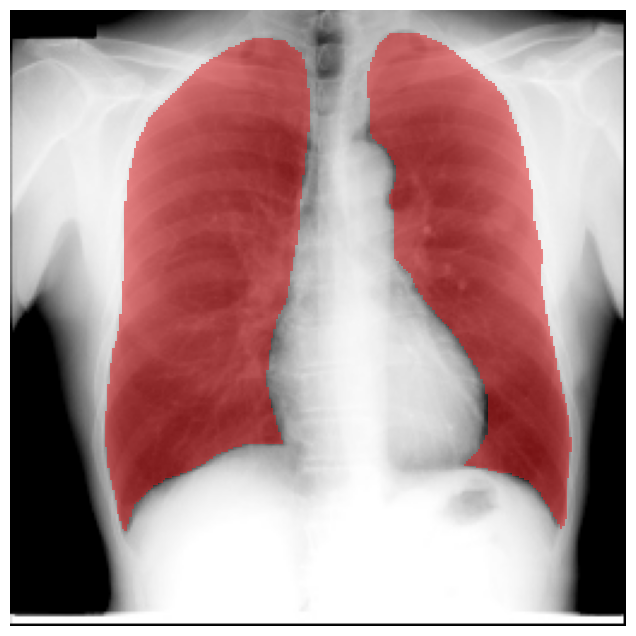

In [18]:

# your data should pass the following asserts
assert x_train.shape == (112, 256, 256, 3)
assert y_train.shape == (112, 256, 256)
assert x_val.shape == (12, 256, 256, 3)
assert y_val.shape == (12, 256, 256)
assert x_test.shape == (123, 256, 256, 3)
assert y_test.shape == (123, 256, 256)

assert x_train.dtype == y_train.dtype == np.uint8
assert np.min(x_train) == 0
assert np.max(x_train) == 255
example_mask = y_train[0].copy()
# Plot an example
fig, ax = plot_image_with_segmentation(x_train[0], example_mask)
plt.show()

# Single Example image

Let's try to run SAM on a single example image

In [19]:
# Calculate Center of Mass (COM) for each mask, and subsequently the COM of all COMs
from scipy.ndimage import center_of_mass

def calculate_coms_for_sides(masks):
    left_coms = []
    right_coms = []
    center_split = 128  # Split masks in the middle
    for mask in masks:
        left_mask, right_mask = mask.copy(), mask.copy()
        left_mask[:, center_split:] = 0 # Left side mask (x from 0 to 127)
        right_mask[:, :center_split] = 0 # Right side mask (x from 128 to 255)

        # Calculate COM for each side if there are any positive pixels
        if np.any(left_mask):
            left_com = center_of_mass(left_mask)
            # Adjust x-coordinate for left side to fit the original mask coordinates
            left_com = (left_com[0], left_com[1])
            left_coms.append(left_com)
        
        if np.any(right_mask):
            right_com = center_of_mass(right_mask)
            # Adjust x-coordinate for right side to fit the original mask coordinates
            right_com = (right_com[0], right_com[1])
            right_coms.append(right_com)
    
    return np.array(left_coms), np.array(right_coms)

def calculate_mean_com(coms):
    """Returns mean as an integer"""
    mean = np.mean(coms, axis=0)
    rounded = np.round(mean).astype(int)
    xy_correction = np.array([rounded[1], rounded[0]])
    return xy_correction

In [20]:
left_lung_coms, right_lung_coms = calculate_coms_for_sides(y_train)
left_lung_mean_com = calculate_mean_com(left_lung_coms)
right_lung_mean_com = calculate_mean_com(right_lung_coms)

In [21]:
example_img, example_mask = x_train[0], y_train[0]

input_points = np.array([left_lung_mean_com, right_lung_mean_com, [128, 128], [128, 240], [15, 50], [256-15, 50]]) # Picked left and right lung COM, center, top, and two points close to shoulders
input_label = np.array([1, 1, 0, 0, 0, 0]) # Get labels for the points

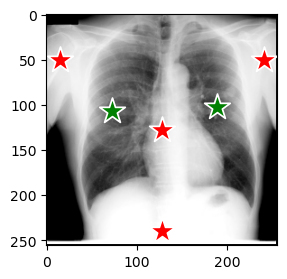

In [22]:
plt.figure(figsize=(3,3))
plt.imshow(example_img)
show_points(input_points, input_label, plt.gca()) # You may also use other prompt methods!
plt.axis('on')
plt.show()

In [23]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=True,
)

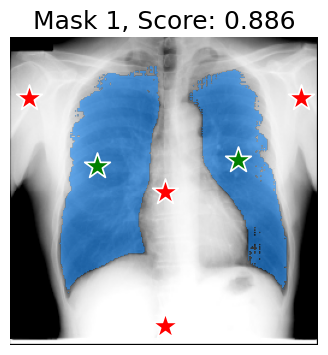

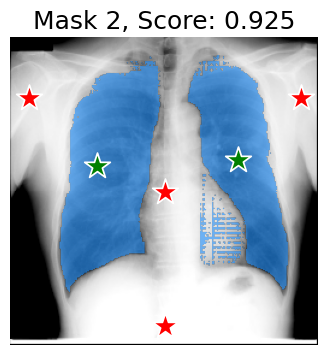

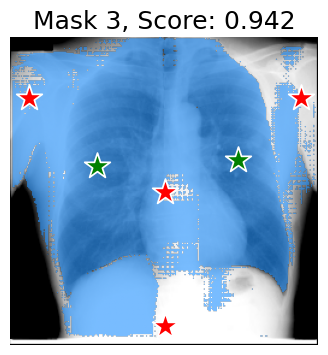

In [24]:
# Note that the "score" here is an estimation of the mask quality, not the quality of the segmentation compared to the ground truth.
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img.squeeze())
    show_mask(mask, plt.gca())
    show_points(input_points, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

# Evaluation loop

In [25]:
import torchmetrics
f1 = torchmetrics.F1Score(task="binary")

f1_scores = []

for img, mask_gt in zip(x_val, y_val):
    predictor.set_image(img)
    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_label,
        multimask_output=True,
    )
    mask_pred = masks[np.argmax(scores)]

    # Convert numpy arrays to torch tensors
    mask_pred_tensor = torch.tensor(mask_pred, dtype=torch.int)
    mask_gt_tensor = torch.tensor(mask_gt, dtype=torch.int)
    
    # Calculate the F1 score for the current prediction
    current_f1 = f1(mask_pred_tensor, mask_gt_tensor).item()
    f1_scores.append(current_f1)
    print(f"F1 score: {current_f1:.4f}")
    break
    
f1_scores = np.array(f1_scores)
mean_f1 = f1_scores.mean() # TODO: Compute mean F1 score
std_f1 = f1_scores.std() # TODO: Compute standard deviation of F1 scores

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

F1 score: 0.5121
Mean F1 score: 0.5121
Standard deviation: 0.0000


# Using Bounding Boxes from GT segmentations as Prompt

In [26]:
# bounding boxes from segmentation masks
# bonding box format [x0, y0, x1, y1]

# TODO: Implement bounding box extraction from segmentation masks

## Single Image Bounding Box example

In [27]:
# Calculate bounding box from ground truth mask
def box_from_gt(mask):
    """
    Intended input: left gt and right gt
    Returns: list bounding box
    """
    y, x = np.where(mask)
    x0, x1 = x.min(), x.max()
    y0, y1 = y.min(), y.max()
    return [x0, y0, x1, y1]

def calculate_bounding_box(mask):
    """
    Calculate bounding box from mask
    """
    left_gt, right_gt = mask.copy(), mask.copy()
    left_gt[:, 128:] = 0
    right_gt[:, :128] = 0
    return box_from_gt(left_gt), box_from_gt(right_gt)

In [28]:
input_boxes = torch.tensor(calculate_bounding_box(example_mask), device=predictor.device)

In [29]:
predictor.set_image(example_img)
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, example_img.shape[:2])

# This is a different predict method which takes transformed inputs
masks, scores, logits = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    multimask_output=False,
    boxes=transformed_boxes
)

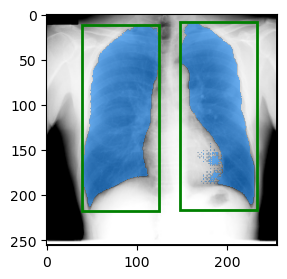

In [30]:
plt.figure(figsize=(3,3))
plt.imshow(example_img)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
for mask in masks:
    show_mask(mask.detach().cpu().numpy(), plt.gca())
plt.axis('on')
plt.show()

## train, val and test boxes from GT

In [31]:
# Generate two bounding boxes for each image from the ground-truth lung segmentation masks for the train, val and test splits
train_boxes = [torch.tensor(calculate_bounding_box(mask), device=predictor.device) for mask in y_train]
val_boxes = [torch.tensor(calculate_bounding_box(mask), device=predictor.device) for mask in y_val]
test_boxes = [torch.tensor(calculate_bounding_box(mask), device=predictor.device) for mask in y_test]

# Transform bounding boxes to the format expected by the SAM model
train_boxes_transformed = [predictor.transform.apply_boxes_torch(box, (256, 256)) for i, box in enumerate(train_boxes)]
val_boxes_transformed = [predictor.transform.apply_boxes_torch(box, (256, 256)) for i, box in enumerate(val_boxes)]
test_boxes_transformed = [predictor.transform.apply_boxes_torch(box, (256, 256)) for i, box in enumerate(test_boxes)]

In [32]:
# Evaluate the bounding box extraction on the validation set
f1_scores = []

f1_box = torchmetrics.F1Score(task="binary")

for i, (img, mask_gt) in enumerate(zip(x_val, y_val)):
    predictor.set_image(img)
    masks, score, logits = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=val_boxes_transformed[i],
        multimask_output=False,
    )
    # Combine the two masks from the two bounding boxes
    mask_combined = (masks[0] + masks[1])[0].detach().cpu().numpy()

    # Convert numpy arrays to torch tensors
    mask_pred_tensor = torch.tensor(mask_combined, dtype=torch.int)
    mask_gt_tensor = torch.tensor(mask_gt, dtype=torch.int)
    
    # Calculate the F1 score for the current prediction
    current_f1 = f1_box(mask_pred_tensor, mask_gt_tensor).item()
    f1_scores.append(current_f1)
    
f1_scores = np.array(f1_scores)
mean_f1 = f1_scores.mean() # TODO: Compute mean F1 score
std_f1 = f1_scores.std() # TODO: Compute standard deviation of F1 scores

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")


Mean F1 score: 0.9218
Standard deviation: 0.0226


# Object Detection Model to predict Bounding Boxes

In [33]:
# TODO: Implement an object detection model to find the left and right lung bounding boxes

## YOLO

In [34]:
import cv2
def convert_bbox_to_yolo_format(box, img_width, img_height):
    """Convert bounding box format from [x_min, y_min, x_max, y_max] 
    to string '<classid> <x_center> <y_center> <width> <height>."""
    x_min, y_min, x_max, y_max = box
    x_center = (x_min + x_max) / 2.0 / img_width
    y_center = (y_min + y_max) / 2.0 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height
    x_center, y_center, width, height = x_center.item(), y_center.item(), width.item(), height.item()
    return f"{x_center} {y_center} {width} {height}\n"

def save_yolo_labels(path, images, bboxes):
    """Save YOLO labels for each image in the dataset."""
    os.makedirs(path + '/images', exist_ok=True)
    os.makedirs(path + '/labels', exist_ok=True)
    for i, image in enumerate(images):
        img_path = path + f'/images/image_{i+1}.jpg'
        cv2.imwrite(img_path, image)

        label_path = path + f'/labels/image_{i+1}.txt'
        with open(label_path, 'w') as f:
            for j, box in enumerate(bboxes[i]):
                class_id = j  # 0 for left lung, 1 for right lung
                yolo_format_box = convert_bbox_to_yolo_format(box, 256, 256)
                f.write(f"{class_id} {yolo_format_box}")

In [35]:
file_path = 'datasets/yolo'
save_yolo_labels(file_path + '/x_train', x_train, train_boxes)
save_yolo_labels(file_path + '/x_val', x_val, val_boxes)

In [36]:
import yaml

data = {
    'train': 'C:/Users/hulig/OneDrive - University of Copenhagen/ML/ADL/A4/datasets/yolo/x_train/images',
    'val': 'C:/Users/hulig/OneDrive - University of Copenhagen/ML/ADL/A4/datasets/yolo/x_val/images',
    'nc': 2,
    'names': ['left_lung', 'right_lung']
}

with open('datasets/yolo/dataset.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

In [37]:
from ultralytics import YOLO

model = YOLO("models/yolov8n.pt")

In [38]:
# %cd datasets/yolo

# model.train(data='dataset.yaml', epochs=10, imgsz=256, batch=4, device=device)

# %cd C:/Users/hulig/OneDrive - University of Copenhagen/ML/ADL/A4

In [39]:
save_yolo_labels(file_path + '/x_test', x_test, test_boxes)

# Load the trained model (make sure to replace the path with the correct path to the model)
model = YOLO("datasets/yolo/runs/detect/train52/weights/best.pt")

# Get the predicted bounding boxes
test_filepath = 'datasets/yolo/x_test/images'
predictions = model.predict(test_filepath, verbose=False)

# Plot example GT Bbox with Predicted BBox on Test set 

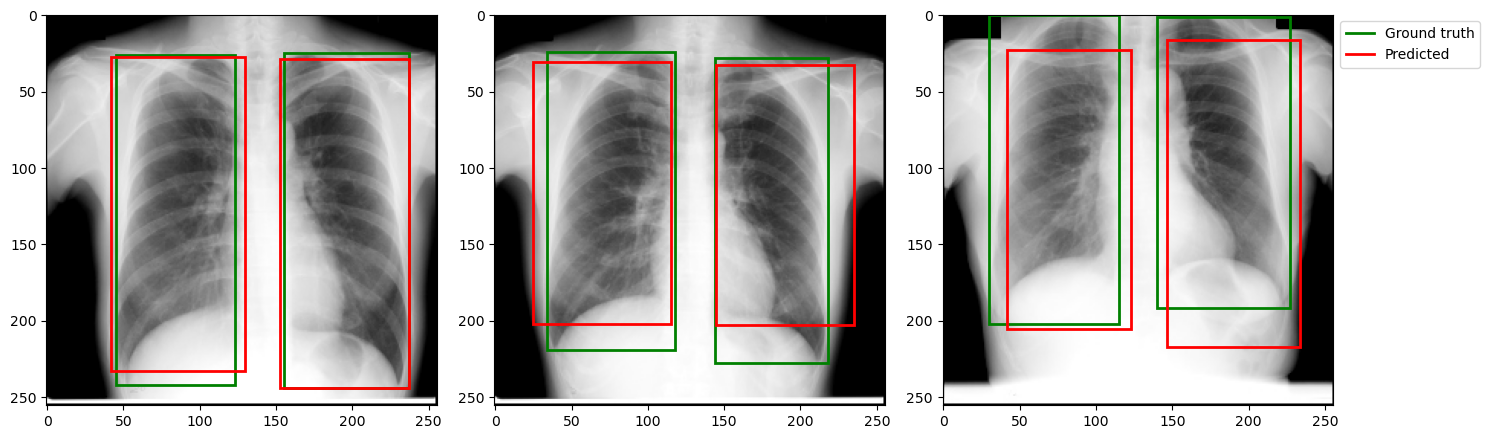

In [108]:
# Select three images, their ground truth boxes, and predictions
from matplotlib.lines import Line2D
indices = [0, 1, 2]
images = [x_test[i] for i in indices]
gt_boxes = [test_boxes[i].detach().cpu().numpy() for i in indices]
pred_boxes = [predictions[i].boxes.xyxy.detach().cpu().numpy() for i in indices]

# Create the plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img, gt_box, pred_box in zip(axes, images, gt_boxes, pred_boxes):
    ax.imshow(img)
    for box in gt_box:
        show_box(box, ax)
    for box in pred_box:
        show_box(box, ax, color='red')
    ax.axis('on')

# Create custom legend handles
legend_elements = [Line2D([0], [0], color='green', lw=2, label='Ground truth'),
                   Line2D([0], [0], color='red', lw=2, label='Predicted')]

# Add legend outside the last subplot
axes[-1].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

## Calculate IoU on test set

In [94]:
from torchvision.ops import box_iou

all_ious = []
for i in range(len(predictions)):
    pred_boxes = predictions[i].boxes.xyxy.detach().cpu().numpy()
    iou = box_iou(torch.tensor(pred_boxes), torch.tensor(test_boxes[i], device='cpu'))
    # assert that iou is a diagonal matrix
    if (iou[0, 1] != 0 and iou[1, 0] != 0):
        if (iou[0, 0] != 0 and iou[1, 1] != 0):
            print(f"IOU matrix is not diagonal for image {i}")
            print(iou)
        break
    all_ious.append(iou.sum())
    
mean_iou = np.mean(np.array(all_ious))/2
print(f"Mean IoU score for predicted images: {mean_iou:.4f}")

Mean IoU score for predicted images: 0.7044


C:\Users\hulig\AppData\Local\Temp\ipykernel_2752\2965382205.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  iou = box_iou(torch.tensor(pred_boxes), torch.tensor(test_boxes[i], device='cpu'))


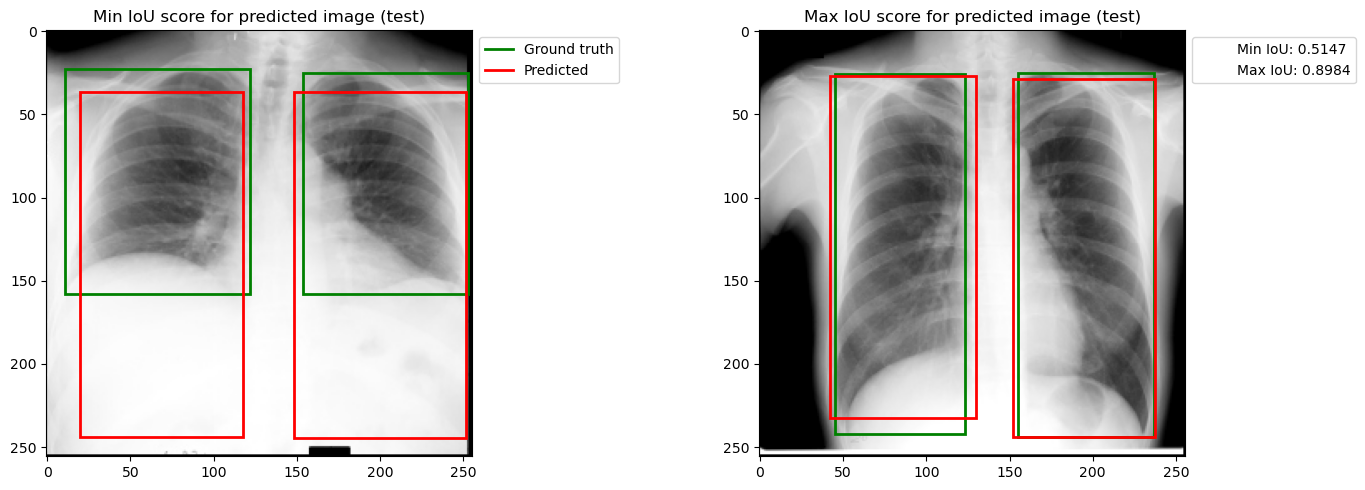

In [120]:
# Get the lowest and highest IoU scores
min_iou, max_iou = min(all_ious) / 2, max(all_ious) / 2

# Get the index of the image with the lowest and highest IoU score
min_iou_index, max_iou_index = all_ious.index(min(all_ious)),  all_ious.index(max(all_ious))

# Select three images, their ground truth boxes, and predictions
from matplotlib.lines import Line2D
indices = [min_iou_index, max_iou_index]
images = [x_test[i] for i in indices]
gt_boxes = [test_boxes[i].detach().cpu().numpy() for i in indices]
pred_boxes = [predictions[i].boxes.xyxy.detach().cpu().numpy() for i in indices]

# Create the plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
titles = ["Min IoU score for predicted image (test)", "Max IoU score for predicted image (test)"]

for ax, img, gt_box, pred_box, title in zip(axes, images, gt_boxes, pred_boxes, titles):
    ax.imshow(img)
    for box in gt_box:
        show_box(box, ax)
    for box in pred_box:
        show_box(box, ax, color='red')
    ax.axis('on')
    ax.set_title(title)

# Create custom legend handles
legend_elements = [Line2D([0], [0], color='green', lw=2, label='Ground truth'),
                   Line2D([0], [0], color='red', lw=2, label='Predicted')]

# Add legend outside the last subplot
axes[0].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

# Create an additional legend for IoU scores
iou_legend_elements = [Line2D([0], [0], color='white', label=f'Min IoU: {min_iou:.4f}'),
                       Line2D([0], [0], color='white', label=f'Max IoU: {max_iou:.4f}')]

# Add the additional IoU legend outside the first subplot
axes[-1].legend(handles=iou_legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

# Prompting SAM with Predicted BBoxes

In [107]:
# Transform predicted bboxes to the format expected by the SAM model
list_of_preds = [pred.boxes.xyxy for pred in predictions]

preds_transformed = [predictor.transform.apply_boxes_torch(box, (256, 256)) for box in list_of_preds]

In [106]:
# Evaluate the bounding box extraction on the validation set
f1_scores = []

f1_box = torchmetrics.F1Score(task="binary")

for i, (img, mask_gt) in enumerate(zip(x_test, y_test)):
    predictor.set_image(img)
    masks, score, logits = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=preds_transformed[i],
        multimask_output=False,
    )
    # Combine the two masks from the two bounding boxes
    mask_combined = (masks[0] + masks[1])[0].detach().cpu().numpy()

    # Convert numpy arrays to torch tensors
    mask_pred_tensor = torch.tensor(mask_combined, dtype=torch.int)
    mask_gt_tensor = torch.tensor(mask_gt, dtype=torch.int)
    
    # Calculate the F1 score for the current prediction
    current_f1 = f1_box(mask_pred_tensor, mask_gt_tensor).item()
    f1_scores.append(current_f1)
    if i % 10 == 0:
        print(f"At iteration {i} with current F1 score: {current_f1:.4f}")
    
f1_scores = np.array(f1_scores)
mean_f1 = f1_scores.mean() # TODO: Compute mean F1 score
std_f1 = f1_scores.std() # TODO: Compute standard deviation of F1 scores

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")


F1 score: 0.9467
At iteration:  0
F1 score: 0.9463
F1 score: 0.8693
F1 score: 0.8520
F1 score: 0.8058
F1 score: 0.9050
F1 score: 0.8759
F1 score: 0.8694
F1 score: 0.8515
F1 score: 0.8318
F1 score: 0.9429
At iteration:  10
F1 score: 0.7045
F1 score: 0.8408
F1 score: 0.9388
F1 score: 0.9148
F1 score: 0.9051
F1 score: 0.7214
F1 score: 0.9230
F1 score: 0.8905
F1 score: 0.7943
F1 score: 0.8024
At iteration:  20
F1 score: 0.8752
F1 score: 0.8854
F1 score: 0.9409
F1 score: 0.9469
F1 score: 0.9463
F1 score: 0.9118
F1 score: 0.9426
F1 score: 0.8529
F1 score: 0.8978
F1 score: 0.9337
At iteration:  30
F1 score: 0.9420
F1 score: 0.8327
F1 score: 0.7703
F1 score: 0.9176
F1 score: 0.8725
F1 score: 0.7809
F1 score: 0.9065
F1 score: 0.9340
F1 score: 0.9289
F1 score: 0.9071
At iteration:  40
F1 score: 0.8848
F1 score: 0.9084
F1 score: 0.9504
F1 score: 0.8987
F1 score: 0.9379
F1 score: 0.9113
F1 score: 0.9389
F1 score: 0.9229
F1 score: 0.8766
F1 score: 0.9102
At iteration:  50
F1 score: 0.7647
F1 score:

In [122]:
# Print standalone for good measure
print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

Mean F1 score: 0.8828
Standard deviation: 0.0735
